# Segmentation using U-Net

## Preparation

### Context
**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

### Content
This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

### Dataset:
https://www.kaggle.com/dansbecker/cityscapes-image-pairs

### References:
- https://arxiv.org/pdf/1603.07285v1.pdf
- https://towardsdatascience.com/u-net-b229b32b4a71
- https://www.kaggle.com/code/dhvananrangrej/image-segmentation-with-unet-pytorch/notebook

<hr>

### Setup of Libraries, Device and Project Directory

In [1]:
import os
import gc
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
base_path = "/scratch/punnavajhala.prakash/segmentation/"

<hr>

### Configuring data locations

In [4]:
data_dir  = os.path.join(base_path, "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir   = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns   = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


<hr>

### Visualize data

/scratch/punnavajhala.prakash/segmentation/cityscapes_data/train/2549.jpg


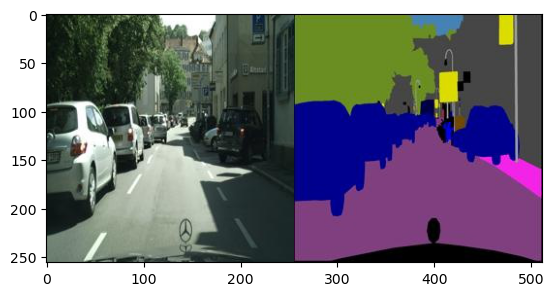

In [5]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image    = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

<hr>

### Extract Image and Labels
The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [6]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

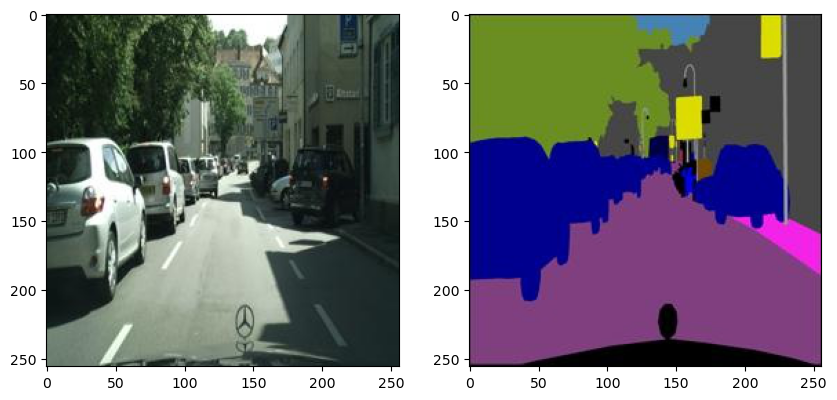

In [7]:
sample_image     = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes        = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(cityscape)
axes[1].imshow(label)
plt.show()

<hr>

### Define Labels
We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [8]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [9]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

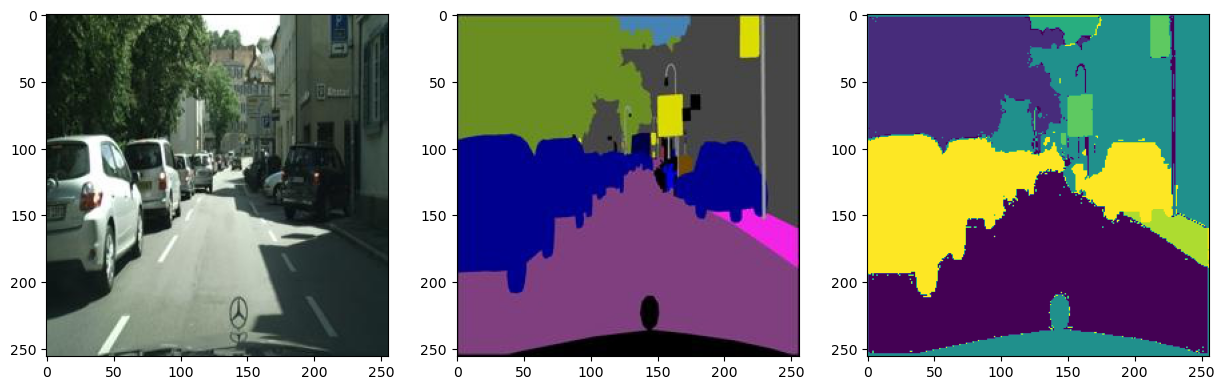

In [10]:
cityscape, label = split_image(sample_image)
label_class      = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes        = plt.subplots(1,3,figsize=(15,5))

axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)
plt.show()

In [11]:
label_class

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 1, 0, ..., 4, 4, 4],
       ...,
       [4, 4, 0, ..., 0, 0, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int32)

<hr>

### Define Dataset

In [12]:
class CityscapeDataset(Dataset):

    def __init__(self, image_dir, label_model):
        self.image_dir   = image_dir
        self.image_fns   = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image    = Image.open(image_fp).convert("RGB")
        image    = np.array(image)

        cityscape, label = self.split_image(image)
        label_class      = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
        label_class      = torch.Tensor(label_class).long()
        cityscape        = self.transform(cityscape)

        return cityscape, label_class

    def split_image(self, image):
        image            = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [13]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [14]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


<hr>

### Define Model 


In [15]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle         = self.conv_block(in_channels=512, out_channels=1024)

        self.expansive_11   = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12   = self.conv_block(   in_channels=1024, out_channels=512)
        self.expansive_21   = nn.ConvTranspose2d(in_channels=512,  out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22   = self.conv_block(   in_channels=512,  out_channels=256)
        self.expansive_31   = nn.ConvTranspose2d(in_channels=256,  out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32   = self.conv_block(   in_channels=256,  out_channels=128)
        self.expansive_41   = nn.ConvTranspose2d(in_channels=128,  out_channels=64,  kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42   = self.conv_block(   in_channels=128,  out_channels=64)

        self.output         = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels)
        )

        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X)                  # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]

        middle_out         = self.middle(contracting_42_out)         # [-1, 1024, 16, 16]

        expansive_11_out   = self.expansive_11(middle_out)           # [-1, 512, 32, 32]
        expansive_12_out   = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out   = self.expansive_21(expansive_12_out)     # [-1, 256, 64, 64]
        expansive_22_out   = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out   = self.expansive_31(expansive_22_out)     # [-1, 128, 128, 128]
        expansive_32_out   = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out   = self.expansive_41(expansive_32_out)     # [-1, 64, 256, 256]
        expansive_42_out   = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]

        output_out         = self.output(expansive_42_out)           # [-1, num_classes, 256, 256]

        return output_out

In [16]:
model = UNet(num_classes=num_classes)

In [17]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [18]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


<hr>

### Train the model

In [19]:
batch_size = 16
epochs     = 10
lr         = 0.01

In [20]:
dataset     = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [21]:
del model

torch.cuda.empty_cache()
gc.collect()

model_UNet = UNet(num_classes = num_classes).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_UNet.parameters(), lr = lr)

In [23]:
UNet_step_losses  = []
UNet_epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))

    progress_bar.set_description(f"Epoch {epoch + 1}/{epochs}")

    for i, (X_train, Y_train) in progress_bar:
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        optimizer.zero_grad()

        Y_train_pred = model_UNet(X_train)

        loss = criterion(Y_train_pred, Y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        UNet_step_losses.append(loss.item())

        progress_bar.set_postfix_str(f"Running mean epoch loss: {(epoch_loss / (i + 1)):.4f}")

    UNet_epoch_losses.append(epoch_loss / len(data_loader))

Epoch 10/10: 100%|██████████| 186/186 [01:37<00:00,  1.91it/s, Running mean epoch loss: 0.4995]


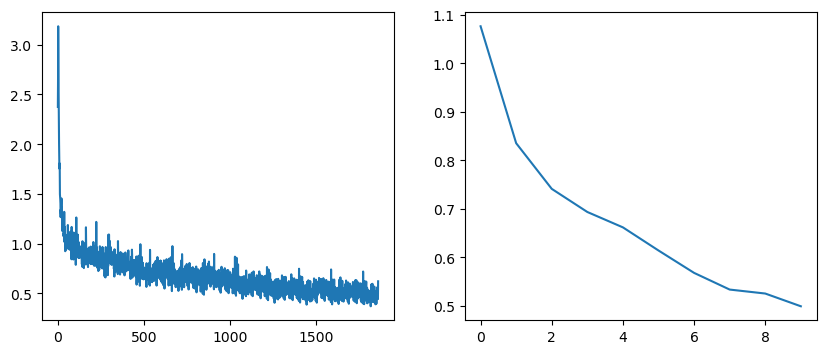

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(UNet_step_losses)
axes[1].plot(UNet_epoch_losses)
plt.show()

In [25]:
model_UNet_path = os.path.join(base_path, "UNet.pth")
torch.save(model_UNet.state_dict(), model_UNet_path)

<hr>

### Check model predictions

In [26]:
model_UNet_path = os.path.join(base_path, "UNet.pth")
model_UNet_pth  = UNet(num_classes=num_classes).to(device)
model_UNet_pth.load_state_dict(torch.load(model_UNet_path))

<All keys matched successfully>

In [27]:
test_batch_size = 10
dataset         = CityscapeDataset(val_dir, label_model)
data_loader     = DataLoader(dataset, batch_size=test_batch_size)

In [28]:
X_val, Y_val = next(iter(data_loader))
X_val, Y_val = X_val.to(device), Y_val.to(device)

Y_val_pred   = model_UNet_pth(X_val)
print(Y_val_pred.shape)

Y_val_pred   = torch.argmax(Y_val_pred, dim=1)
print(Y_val_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [29]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

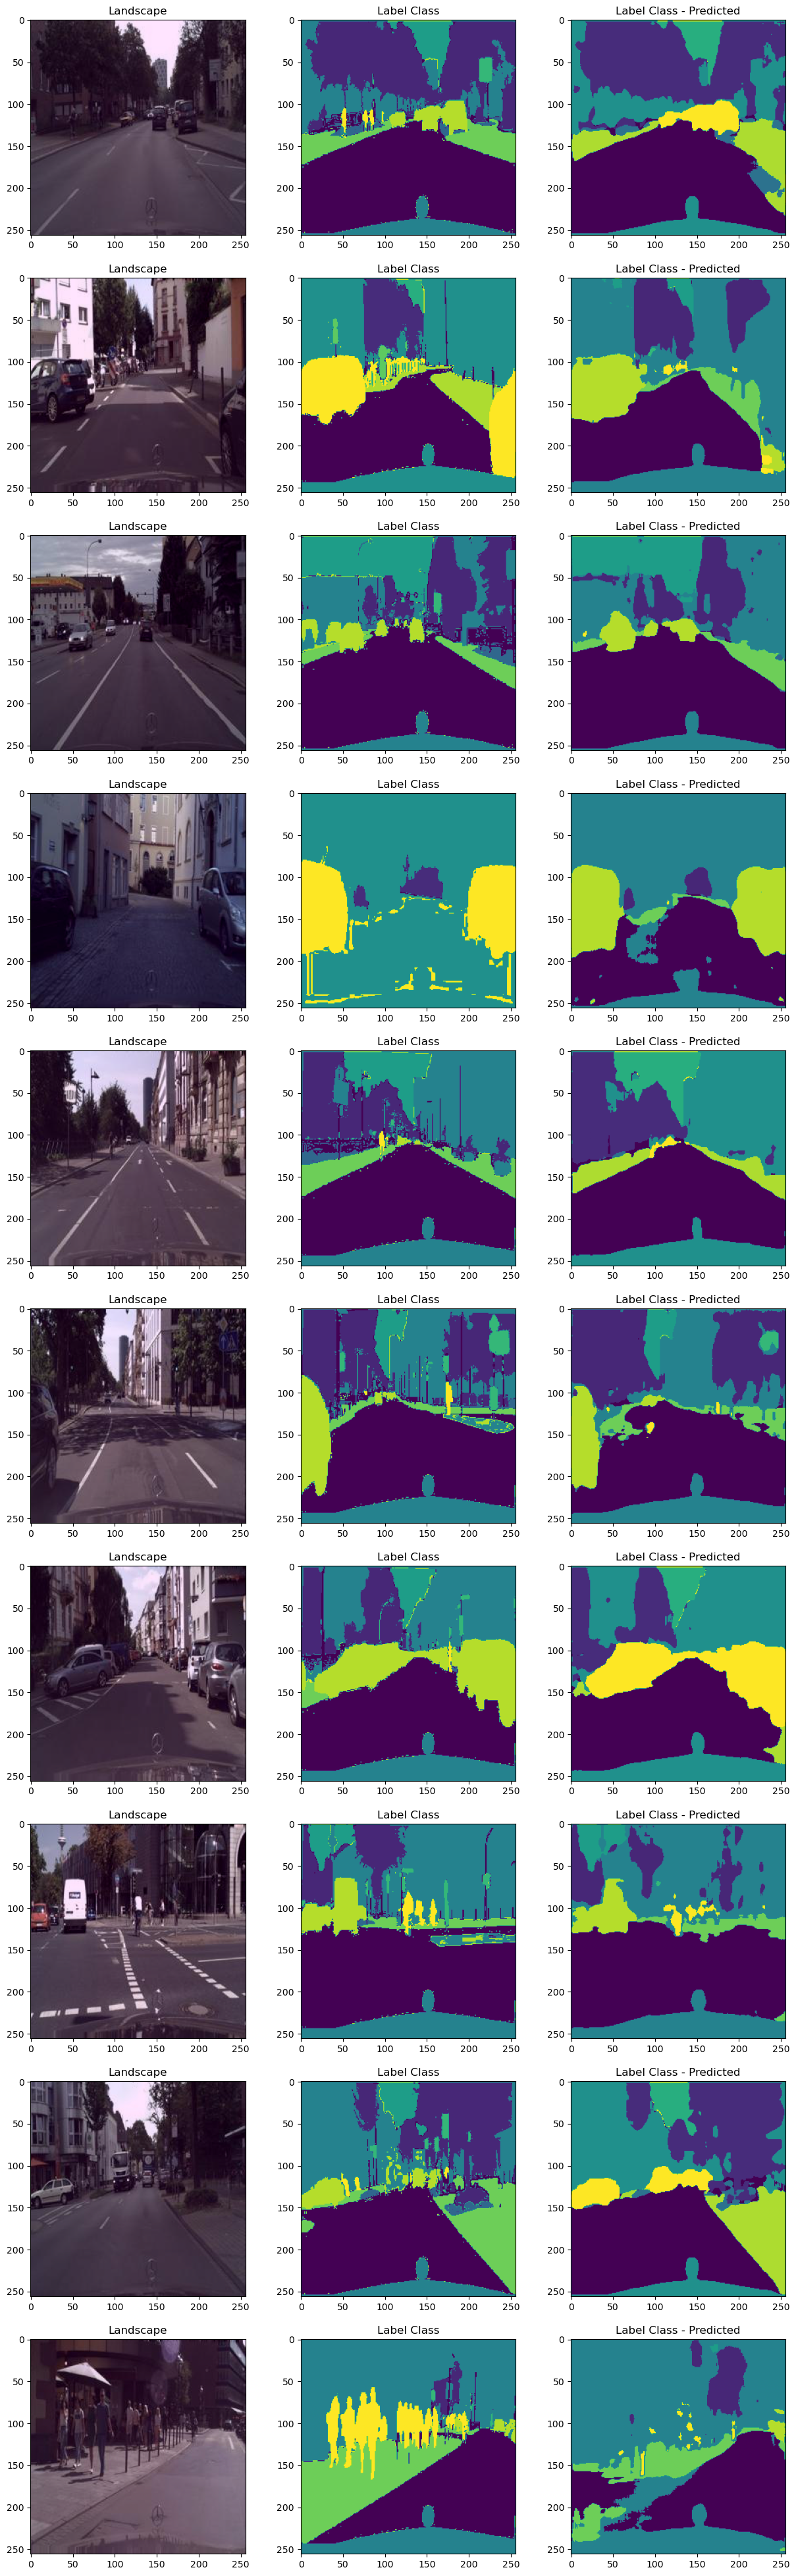

In [30]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape             = inverse_transform(X_val[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class           = np.array(Y_val[i].cpu().detach().numpy(), dtype=int)
    label_class_predicted = np.array(Y_val_pred[i].cpu().detach().numpy(), dtype=int)

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union        = np.logical_or(label_class, label_class_predicted)
    iou_score    = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [31]:
print(sum(iou_scores) / len(iou_scores))

0.8989949921632017


<hr>

## Importance of skip connections

In [32]:
class UNetNoSkip(UNet):
        
        def __init__(self, num_classes):
            super(UNetNoSkip, self).__init__(num_classes)

            self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
            self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
            self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
            self.expansive_42 = self.conv_block(in_channels=64,  out_channels=64)

        def forward(self, X):
            contracting_11_out = self.contracting_11(X)                  # [-1, 64, 256, 256]
            contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
            contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
            contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
            contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
            contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
            contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
            contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]

            middle_out         = self.middle(contracting_42_out)         # [-1, 1024, 16, 16]

            expansive_11_out   = self.expansive_11(middle_out)           # [-1, 512, 32, 32]
            expansive_12_out   = self.expansive_12(expansive_11_out)     # [-1, 512, 32, 32]
            expansive_21_out   = self.expansive_21(expansive_12_out)     # [-1, 256, 64, 64]
            expansive_22_out   = self.expansive_22(expansive_21_out)     # [-1, 256, 64, 64]
            expansive_31_out   = self.expansive_31(expansive_22_out)     # [-1, 128, 128, 128]
            expansive_32_out   = self.expansive_32(expansive_31_out)     # [-1, 128, 128, 128]
            expansive_41_out   = self.expansive_41(expansive_32_out)     # [-1, 64, 256, 256]
            expansive_42_out   = self.expansive_42(expansive_41_out)     # [-1, 64, 256, 256]

            output_out         = self.output(expansive_42_out)           # [-1, num_classes, 256, 256]

            return output_out

In [33]:
batch_size = 16
epochs     = 10
lr         = 0.01

In [34]:
dataset     = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [35]:
torch.cuda.empty_cache()
gc.collect()

model_UNet_no_skip = UNetNoSkip(num_classes = num_classes).to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_UNet_no_skip.parameters(), lr = lr)

In [37]:
UNet_no_skip_step_losses  = []
UNet_no_skip_epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))

    progress_bar.set_description(f"Epoch {epoch + 1}/{epochs}")

    for i, (X_train, Y_train) in progress_bar:
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        optimizer.zero_grad()

        Y_train_pred = model_UNet_no_skip(X_train)

        loss = criterion(Y_train_pred, Y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        UNet_no_skip_step_losses.append(loss.item())

        progress_bar.set_postfix_str(f"Running mean epoch loss: {(epoch_loss / (i + 1)):.4f}")

    UNet_no_skip_epoch_losses.append(epoch_loss / len(data_loader))

Epoch 10/10: 100%|██████████| 186/186 [01:25<00:00,  2.18it/s, Running mean epoch loss: 0.5125]


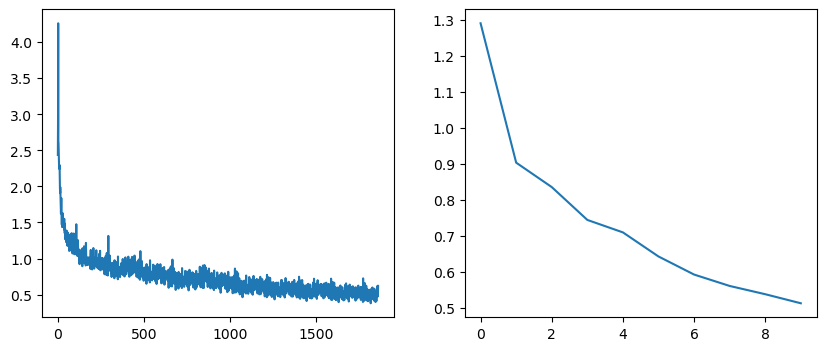

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(UNet_no_skip_step_losses)
axes[1].plot(UNet_no_skip_epoch_losses)
plt.show()

In [39]:
model_UNet_no_skip_path = os.path.join(base_path, "UNet_no_skip.pth")
torch.save(model_UNet_no_skip.state_dict(), model_UNet_no_skip_path)

In [40]:
model_UNet_no_skip_path = os.path.join(base_path, "UNet_no_skip.pth")
model_UNet_no_skip_pth  = UNetNoSkip(num_classes=num_classes).to(device)
model_UNet_no_skip_pth.load_state_dict(torch.load(model_UNet_no_skip_path))

<All keys matched successfully>

In [41]:
Y_val_pred_no_skip = model_UNet_no_skip_pth(X_val)
print(Y_val_pred_no_skip.shape)

Y_val_pred_no_skip = torch.argmax(Y_val_pred_no_skip, dim=1)
print(Y_val_pred_no_skip.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [42]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


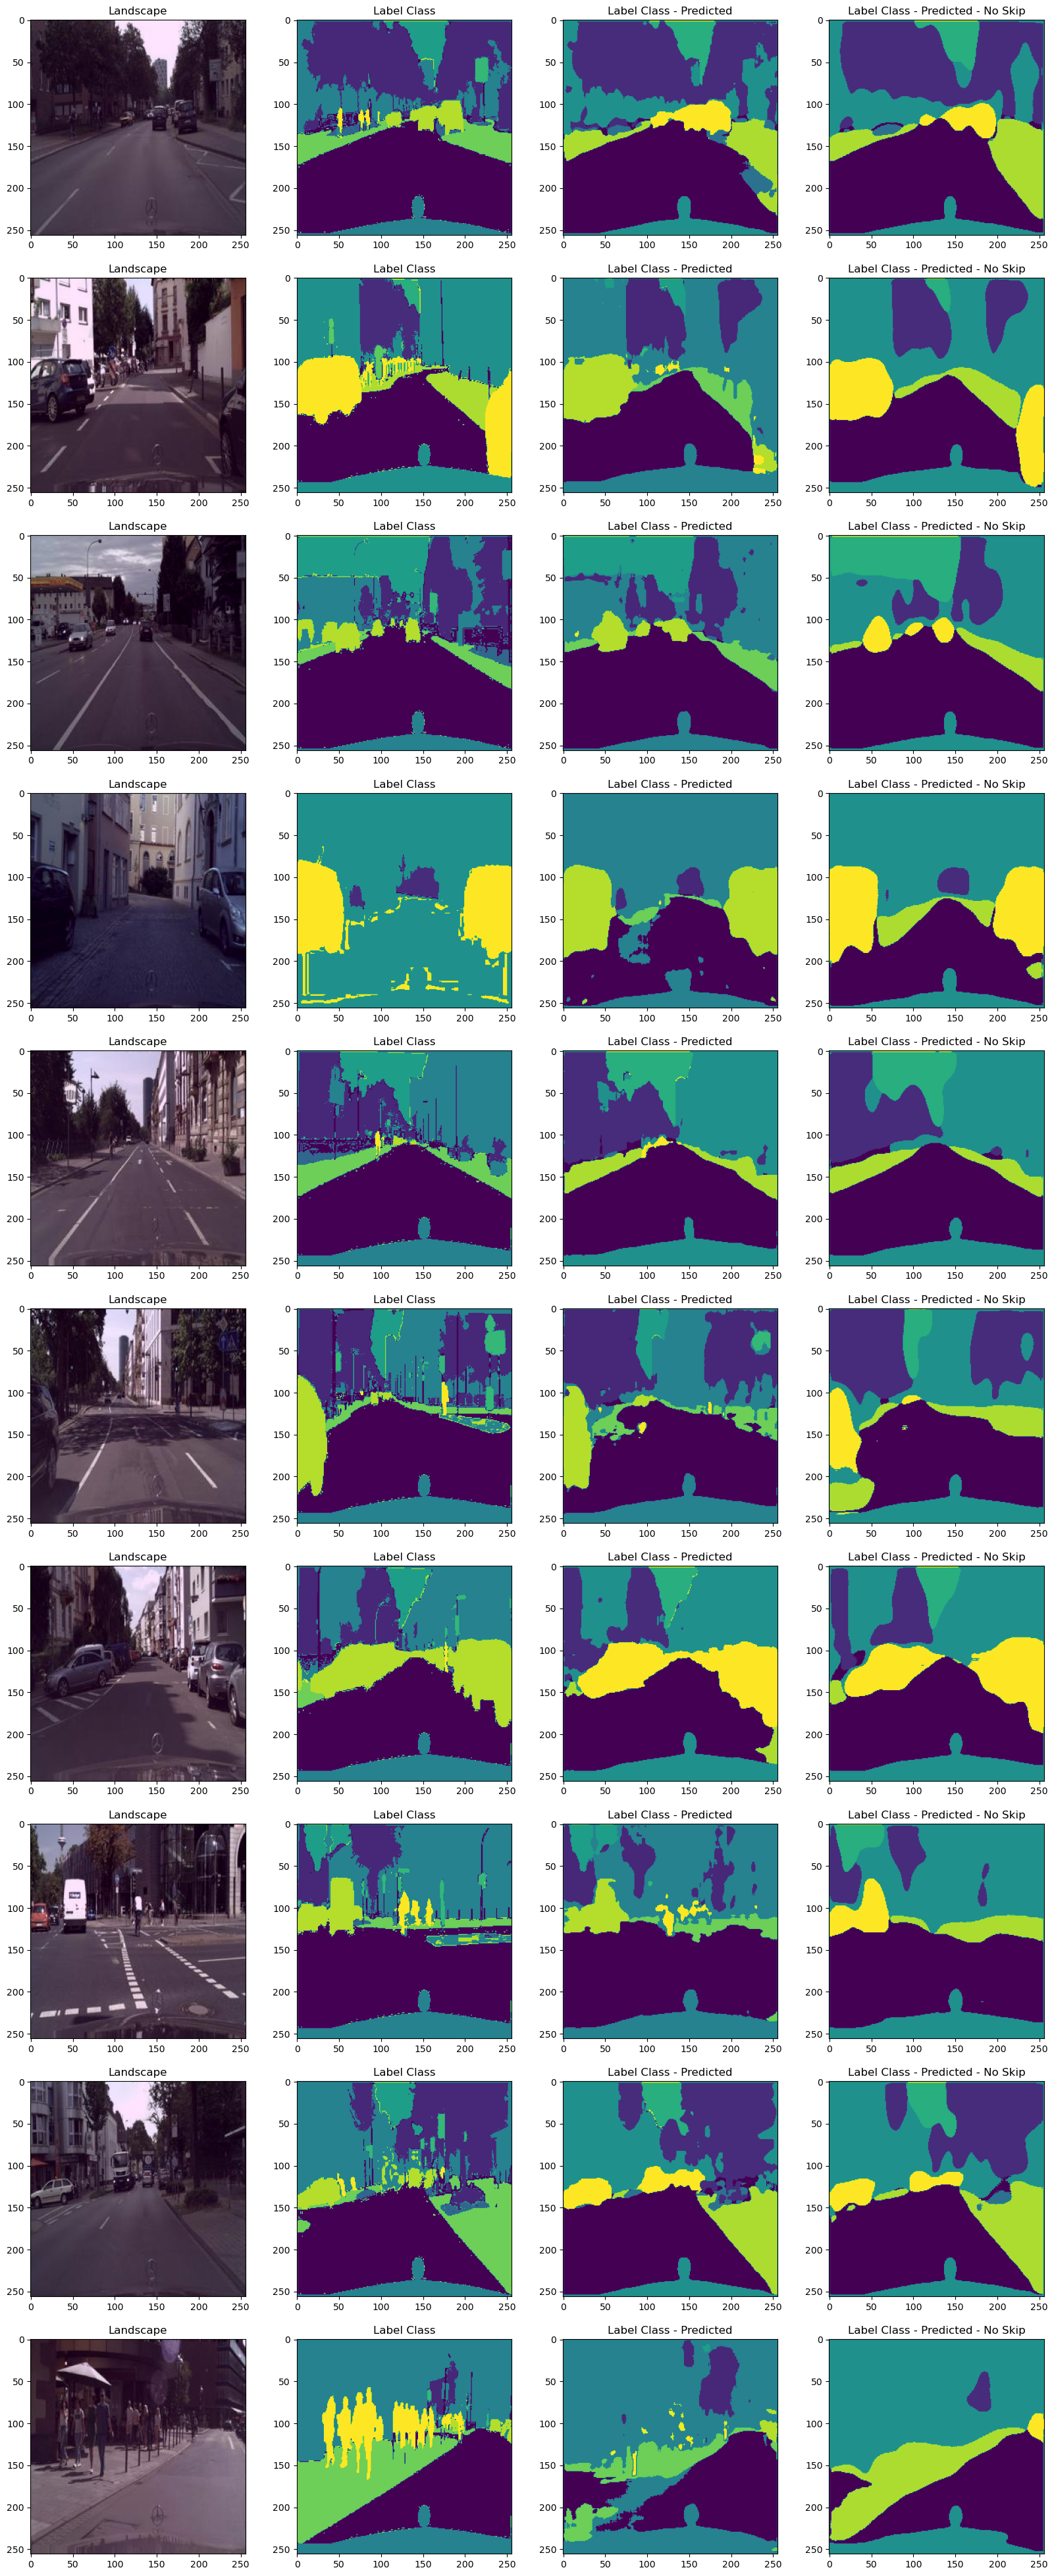

In [43]:
fig, axes = plt.subplots(test_batch_size, 4, figsize=(4*5, test_batch_size*5))

iou_scores_no_skip = []

for i in range(test_batch_size):

    landscape                     = inverse_transform(X_val[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class                   = np.array(Y_val[i].cpu().detach().numpy(), dtype=int)
    label_class_predicted         = np.array(Y_val_pred[i].cpu().detach().numpy(), dtype=int)
    label_class_predicted_no_skip = np.array(Y_val_pred_no_skip[i].cpu().detach().numpy(), dtype=int)

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted_no_skip)
    union        = np.logical_or(label_class, label_class_predicted_no_skip)
    iou_score    = np.sum(intersection) / np.sum(union)
    iou_scores_no_skip.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")
    axes[i, 3].imshow(label_class_predicted_no_skip)
    axes[i, 3].set_title("Label Class - Predicted - No Skip")

In [44]:
print("With skip connections")
print(sum(iou_scores) / len(iou_scores))

print("Without skip connections")
print(sum(iou_scores_no_skip) / len(iou_scores_no_skip))

With skip connections
0.8989949921632017
Without skip connections
0.9015021898262108


<hr>

## Metric - IoU (Intersection over Union)

- #### The metric from the reference notebook is computing the IoU score over the arrays `label_class` and `label_class_prediction`, which contain the class labels of the ground truth and the predicted image respectively, which range from `0` to `num_classes`
- #### The union and intersection are calculated using the `logical_or` and `logical_and` functions respectively, which is obviously wrong, as the arrays are not binary mask entries. Rather, they are class labels.
- #### Hence the correct approach would be to prepare class-wise masks over the arrays and then compute the union and intersection over these class-wise masked arrays

In [45]:
def class_wise_IoU(Y_true, Y_pred, class_label):
    intersection = np.logical_and(Y_true == class_label, Y_pred == class_label)
    union        = np.logical_or( Y_true == class_label, Y_pred == class_label)
    return np.sum(intersection) / np.sum(union)

In [46]:
new_iou_scores         = []
new_iou_scores_no_skip = []

for i in range(test_batch_size):
    label_class                   = np.array(Y_val[i].cpu().detach().numpy(), dtype=int)
    label_class_predicted         = np.array(Y_val_pred[i].cpu().detach().numpy(), dtype=int)
    label_class_predicted_no_skip = np.array(Y_val_pred_no_skip[i].cpu().detach().numpy(), dtype=int)

    new_iou_class_wise         = []
    new_iou_class_wise_no_skip = []

    for class_label in np.unique(label_class):
        iou_score         = class_wise_IoU(label_class, label_class_predicted, class_label)
        iou_score_no_skip = class_wise_IoU(label_class, label_class_predicted_no_skip, class_label)

        new_iou_class_wise.append(iou_score)
        new_iou_class_wise_no_skip.append(iou_score_no_skip)

    new_iou_scores.append(np.mean(new_iou_class_wise))
    new_iou_scores_no_skip.append(np.mean(new_iou_class_wise_no_skip))

print("Corrected IoU score with skip connections")
print(sum(new_iou_scores) / len(new_iou_scores))

print("Corrected IoU score without skip connections")
print(sum(new_iou_scores_no_skip) / len(new_iou_scores_no_skip))

Corrected IoU score with skip connections
0.4335380223750989
Corrected IoU score without skip connections
0.41809564014006134


<hr>

## Observations

- #### The mIoU score (mean IoU) is different the UNet architectures with and without skip connections.
- #### This is observed as the skip connections help in retaining finer information which is generally present in the initial layers and is lost in the later layers as the later layers generally only capture the higher level features
- #### The similar trend can be observed in the segmentation masks predicted by both the models, where we can see that the model with the skip connections has finer and sharper segmentation masks while the one without skip connections has a more "blob"-like boundaries that are obviously less accurate
- #### We can also observe that the corrected IoU metric represents the performance of the models better. We can confirm this from the qualitative analysis of the predicted segmentation masks (from the above plots), where we can notice that the models are not quite there at the level of the ground truth masks, while the previous IoU metric was giving the scores of around `0.9`, which is extremely good performance and is definitely not the case for the above models as can be inferred from the above plots

<hr>